In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import numpy as np
import pandas as pd
import datetime as dt

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [14]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
session.query(Measurement.date).\
    order_by(Measurement.date).all()

[('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-01',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-02',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-03',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-04',),
 ('2010-01-05',),
 ('2010-01-05',),
 ('2010-01-05',),
 ('2010-01-05',),
 ('2010-01-05',),
 ('2010-01-05',),
 ('2010-01-06',),
 ('2010-01-06',),
 ('2010-01-06',),
 ('2010-01-06',),
 ('2010-01-06',),
 ('2010-01-06',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-07',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-08',),
 ('2010-01-09',),
 ('2010-01

The most recent data point is 2017-08-23.
The date one year from the last date is 2016-08-23.


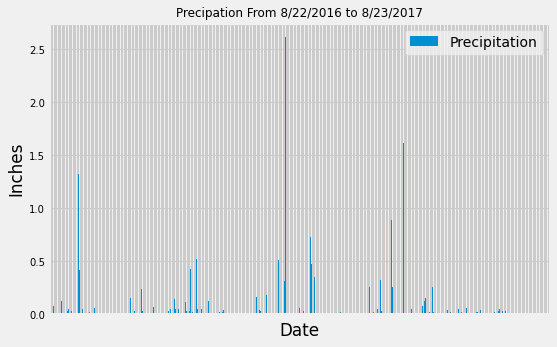

In [26]:
 # Query date and prcp data for last 12 mos
last_12mos = session.query(Measurement.date, Measurement.prcp).\
        group_by(Measurement.date).\
        filter(Measurement.date <='2017-08-23').\
        filter(Measurement.date >='2016-08-22').\
            order_by(Measurement.date).all()
df = pd.DataFrame(last_12mos, columns=["Date", "Precipitation"])
df.head() 
   
#starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent data point is {most_recent_date}.")

# Calculate the date one year from the last date in data set.
most_recent_date_int = [int(i) for i in most_recent_date.split("-")]
one_year_prior = dt.date(*most_recent_date_int) - dt.timedelta(days=365)
print(f"The date one year from the last date is {one_year_prior}.")

# Perform a query to retrieve the data and precipitation scores

recent_12mos_list = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=one_year_prior.strftime('%Y-%m-%d')).order_by(Measurement.date).all()

list_date=[i[0] for i in recent_12mos_list]
list_prcp=[i[1] for i in recent_12mos_list]
# Save the query results as a Pandas DataFrame and set the index to the date column
df_12mos = pd.DataFrame({"Date":list_date, "Prcp":list_prcp}).set_index("Date")
df_12mos.head()

# Sort the dataframe by date
df_12mos = df.sort_values(by="Date").dropna()
df_12mos.head()
# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.ticker import NullFormatter
import matplotlib.dates as mdates

x = df_12mos.plot(kind='bar', x='Date', fontsize=10, y="Precipitation", figsize=(8,5))


x.xaxis.set_major_formatter(NullFormatter())

plt.title('Precipation From 8/22/2016 to 8/23/2017', fontsize=12)
plt.ylabel('Inches')
plt.savefig('Last 12 Months of Precipitation.png', dpi=300)
plt.show()


In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_12mos["Precipitation"].describe()

count    365.000000
mean       0.049671
std        0.205473
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [56]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).count()
print(f"There are {stations} stations in the dataset.")

There are 9 stations in the dataset.


In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
find = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
sel_find = session.query(*find).\
    filter(Measurement.station =="USC00519281").all()
sel_find

[(54.0, 85.0, 71.66378066378067)]

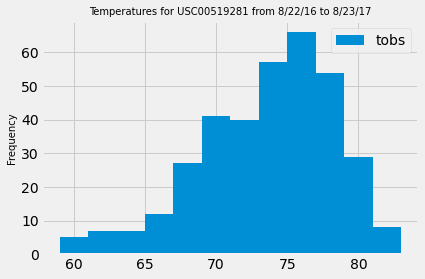

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_lst = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').\
    filter(Measurement.date>='2016-08-22').order_by(Measurement.date).all()
station_lst = [i[0] for i in station_lst]

plt.hist(station_lst, bins=12)

plt.legend(["tobs"])
plt.ylabel("Frequency", fontsize=10)
plt.title("Temperatures for USC00519281 from 8/22/16 to 8/23/17", fontsize=10)


plt.grid(True)


# Close session

In [32]:
# Close Session
session.close()